In [1]:
import numpy as np
import random
import control as ct
import matplotlib.pyplot as plt
import scienceplots

#Exibição dos gráficos em janela externa:
#%matplotlib qt

# Configurações de plot:
plt.style.use([
    'grid',
    'retro'
])
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 16 
plt.rcParams['figure.figsize'] = (12, 6)

<h1 align='center'>Simulação do Sistema:<h1>

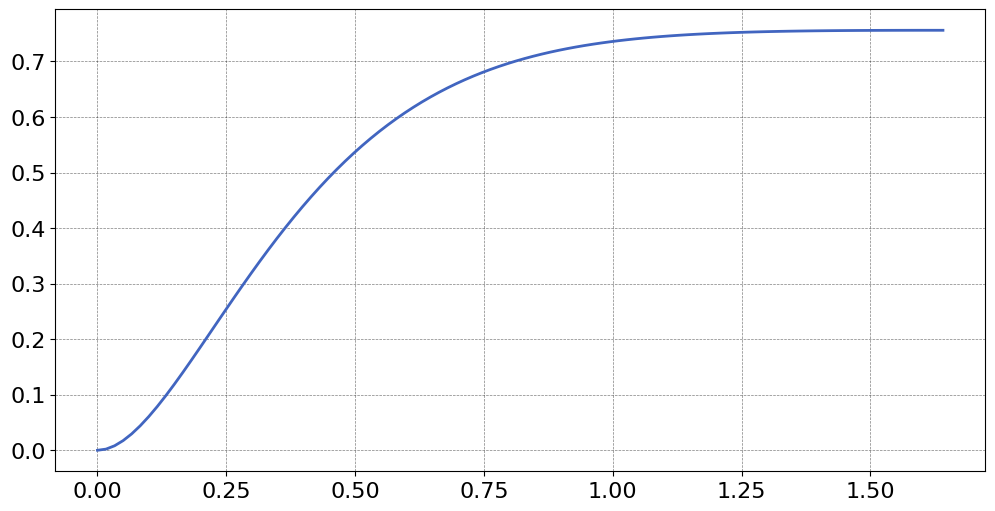

In [2]:
s = ct.tf('s')

G = (16.17/((s**2)+(8.421*s)+21.41))

sol = ct.step_response(G)

plt.figure()
plt.plot(sol[0], sol[1])
plt.show()

<h1 align='center'>Aplicando o PRBS:<h1>

In [3]:
#Função para gerar um prbs:
def getPRBS(ts, tau, duration):
    amp = 3 #Qualquer valor inicial, diferente de -1, 0 ou 1 (só para iniciar a variável)
    prbs = np.array([]) #Criando um vetor vazio para armazenar o prbs
    while(True):
        #Amplitude de cada impulso:
        while(True):
            val = random.randint(-1, 1)
            if(val != amp):
                amp = val
                break

        #Duração de cada impulso:
        d = random.randint(int(tau/10), int(tau/3))

        #Cria o impulso e adiciona à lista prbs:
        prbs = np.hstack((prbs, np.ones(int(d/ts))*amp))

        #Condição de parada para a criação do prbs:
        if(len(prbs)>((duration*1e3)/ts)):
            break
    return prbs[:int(duration*1e3/ts)] #Garante que o PRBS tenha exatamente a duração desejada

C:\Users\Erick\AppData\Local\Temp\ipykernel_12892\514273469.py:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


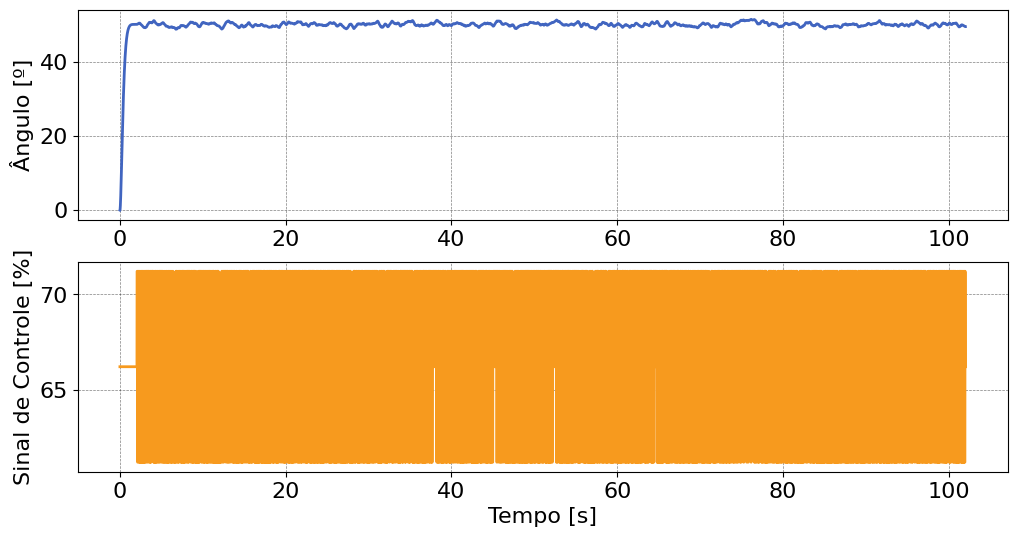

In [4]:
#Constante de tempo do sistema, em ms:
tau = 800/4

#Tempo de amostragem desejada, em ms:
ts = 1

#Tempo final de ensaio, em segundos:
tf = 100

#Tempo de degrau:
tdeg = (10*tau)

#Criando vetor de tempo:
t = np.arange(0, tf+int(tdeg*1e-3), ts*1e-3)

#Criando o vetor de sinal:
pop = 50
ueq = pop/ct.dcgain(G) #Calculado com ganho estático e ponto de operação
u = np.hstack((np.ones(int(tdeg/ts))*ueq, (getPRBS(ts, tau, tf)*5)+ueq))

#Simulação do sistema:
t, y = ct.forced_response(G, t, u)

#Plot da resposta:
plt.subplots(sharex=True)
plt.subplot(2, 1, 1)
plt.plot(t, y, color='C0')
plt.ylabel('Ângulo [º]')
plt.subplot(2, 1, 2)
plt.plot(t, u, color='C4')
plt.ylabel('Sinal de Controle [%]')
plt.xlabel('Tempo [s]')
plt.show()

<h1 align='center'>Convolução:<h1>

In [5]:
#Ordem desejada para o modelo:
n = 1000

#Seleção apenas do regime permanente:
uc = u[int(tdeg/ts):]
yc = y[int(tdeg/ts):]

#Preenchimento da matriz U:
U = []
for k in range(n, len(uc)):
    U.append(np.flip(uc[k-n:k]))
U = np.array(U)

#Criação do vetor Y:
Y = yc[n:].T

#Obtenção dos coeficientes (matriz H) por Estimador de Mínimos Quadrados:
H = np.linalg.inv(U.T@U)@U.T@Y

C:\Users\Erick\AppData\Local\Temp\ipykernel_12892\804659951.py:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


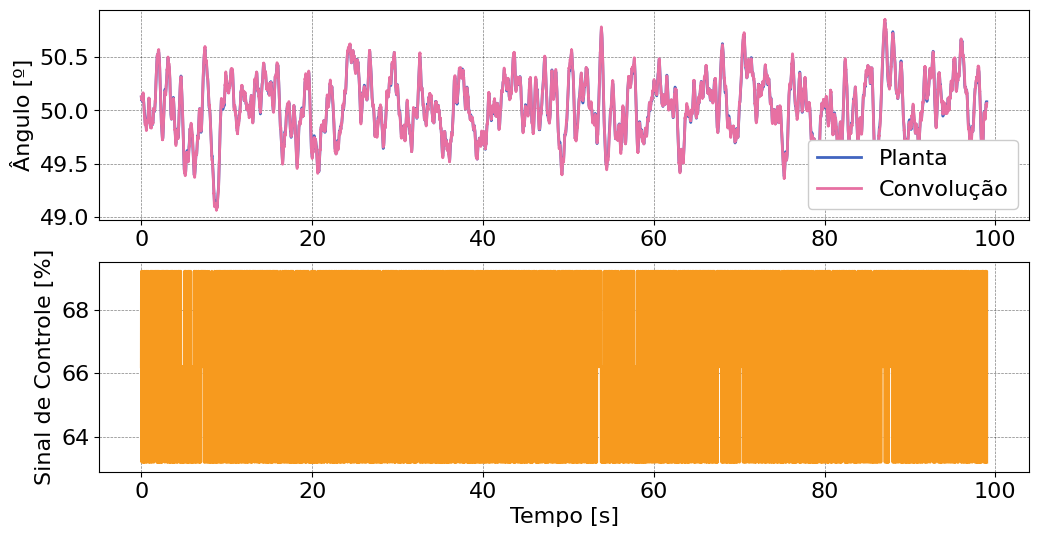

In [6]:
#Criação de outro prbs para validação do modelo:
uvalid = np.hstack((np.ones(int(tdeg/ts))*ueq, ueq+(getPRBS(ts, tau, tf)*3)))
tvalid = np.arange(0, tf+(tdeg*1e-3), ts*1e-3)

#Simulação do modelo de convolução:
#Preenchimento da matriz U:
Uvalid = []
for k in range(n, len(uvalid)):
    Uvalid.append(np.flip(uvalid[k-n:k]))
Uvalid = np.array(Uvalid)
#Saída do modelo:
yconv = Uvalid@H

#Simulação da planta:
tvalid, yplanta = ct.forced_response(G, tvalid, uvalid)

#Decupagem dos dados:
tvalid = tvalid[int(tdeg/ts)+n:]-int((int(tdeg/ts)+n)*1e-3)
uvalid = uvalid[int(tdeg/ts)+n:]
yplanta = yplanta[int(tdeg/ts)+n:]
yconv = yconv[int(tdeg/ts):]

#Plot da resposta:
plt.subplots(sharex=True)
plt.subplot(2, 1, 1)
plt.plot(tvalid, yplanta, color='C0', label='Planta')
plt.plot(tvalid, yconv, color='C1', label='Convolução')
plt.ylabel('Ângulo [º]')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(tvalid, uvalid, color='C4')
plt.ylabel('Sinal de Controle [%]')
plt.xlabel('Tempo [s]')
plt.show()

C:\Users\Erick\AppData\Local\Temp\ipykernel_12892\4048825444.py:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


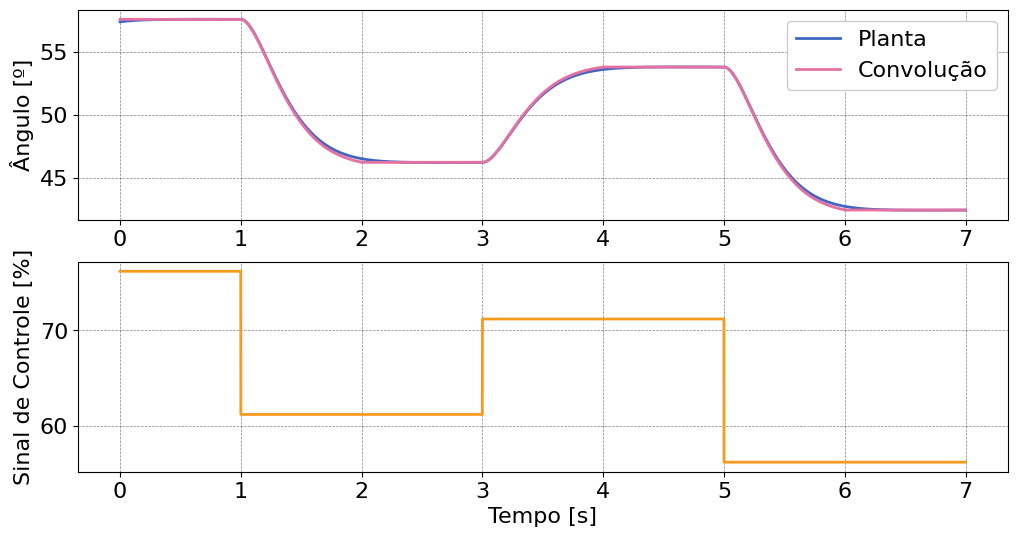

In [7]:
#Criação de degraus para validação do modelo:
uvalid = np.hstack((np.ones(int(tdeg/ts))*ueq, np.ones(int(tdeg/ts))*(ueq+10), np.ones(int(tdeg/ts))*(ueq-5), np.ones(int(tdeg/ts))*(ueq+5), np.ones(int(tdeg/ts))*(ueq-10)))
tvalid = np.arange(0, int(5*tdeg*1e-3), ts*1e-3)

#Simulação do modelo de convolução:
#Preenchimento da matriz U:
Uvalid = []
for k in range(n, len(uvalid)):
    Uvalid.append(np.flip(uvalid[k-n:k]))
Uvalid = np.array(Uvalid)
#Saída do modelo:
yconv = Uvalid@H

#Simulação da planta:
tvalid, yplanta = ct.forced_response(G, tvalid, uvalid)

#Decupagem dos dados:
tvalid = tvalid[int(tdeg/ts)+n:]-int((int(tdeg/ts)+n)*1e-3)
uvalid = uvalid[int(tdeg/ts)+n:]
yplanta = yplanta[int(tdeg/ts)+n:]
yconv = yconv[int(tdeg/ts):]

#Plot da resposta:
plt.subplots(sharex=True)
plt.subplot(2, 1, 1)
plt.plot(tvalid, yplanta, color='C0', label='Planta')
plt.plot(tvalid, yconv, color='C1', label='Convolução')
plt.ylabel('Ângulo [º]')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(tvalid, uvalid, color='C4')
plt.ylabel('Sinal de Controle [%]')
plt.xlabel('Tempo [s]')
plt.show()

<h1 align='center'>ARX:<h1>

In [8]:
#Seleção apenas do regime permanente:
ua = u[int(tdeg/ts):]
ya = y[int(tdeg/ts):]

#Criação da matriz de estimadores psi:
PSI = []
for k in range(n, len(ua)):
    PSI.append(np.hstack((np.flip(ya[k-n:k-1]), np.flip(ua[k-n:k]))))
PSI = np.array(PSI)

#Obtenção dos coeficientes (matriz theta) por Estimador de Mínimos Quadrados:
THETA = np.linalg.inv(PSI.T@PSI)@PSI.T@Y

C:\Users\Erick\AppData\Local\Temp\ipykernel_12892\517180302.py:9: RuntimeWarning: overflow encountered in matmul
  yk = psi@THETA
C:\Users\Erick\AppData\Local\Temp\ipykernel_12892\517180302.py:9: RuntimeWarning: invalid value encountered in matmul
  yk = psi@THETA
C:\Users\Erick\AppData\Local\Temp\ipykernel_12892\517180302.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


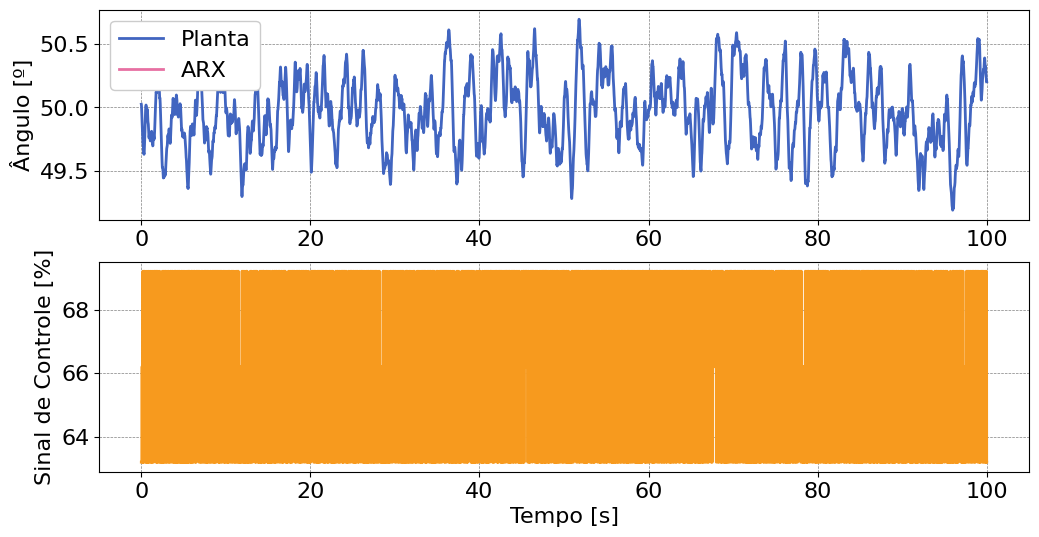

In [9]:
#Criação outro prbs para validação do modelo:
uvalid = np.hstack((np.ones(int(tdeg/ts))*ueq, ueq+(getPRBS(ts, tau, tf)*3)))
tvalid = np.arange(0, tf+(tdeg*1e-3), ts*1e-3)

#Simulação do modelo ARX:
yarx = np.ones(n)*pop
for k in range(n, len(uvalid)):
    psi = np.hstack((np.flip(yarx[k-n:k-1]), np.flip(uvalid[k-n:k])))
    yk = psi@THETA
    yarx = np.hstack((yarx, yk))

#Simulação da planta:
tvalid, yplanta = ct.forced_response(G, tvalid, uvalid)

#Decupagem dos dados:
tvalid = tvalid[int(tdeg/ts):]-int((int(tdeg/ts))*1e-3)
uvalid = uvalid[int(tdeg/ts):]
yplanta = yplanta[int(tdeg/ts):]
yarx = yarx[int(tdeg/ts):]

#Plot da resposta:
plt.subplots(sharex=True)
plt.subplot(2, 1, 1)
plt.plot(tvalid, yplanta, color='C0', label='Planta')
plt.plot(tvalid, yarx, color='C1', label='ARX')
plt.ylabel('Ângulo [º]')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(tvalid, uvalid, color='C4')
plt.ylabel('Sinal de Controle [%]')
plt.xlabel('Tempo [s]')
plt.show()

C:\Users\Erick\AppData\Local\Temp\ipykernel_12892\2703117831.py:9: RuntimeWarning: overflow encountered in matmul
  yk = psi@THETA
C:\Users\Erick\AppData\Local\Temp\ipykernel_12892\2703117831.py:9: RuntimeWarning: invalid value encountered in matmul
  yk = psi@THETA
C:\Users\Erick\AppData\Local\Temp\ipykernel_12892\2703117831.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


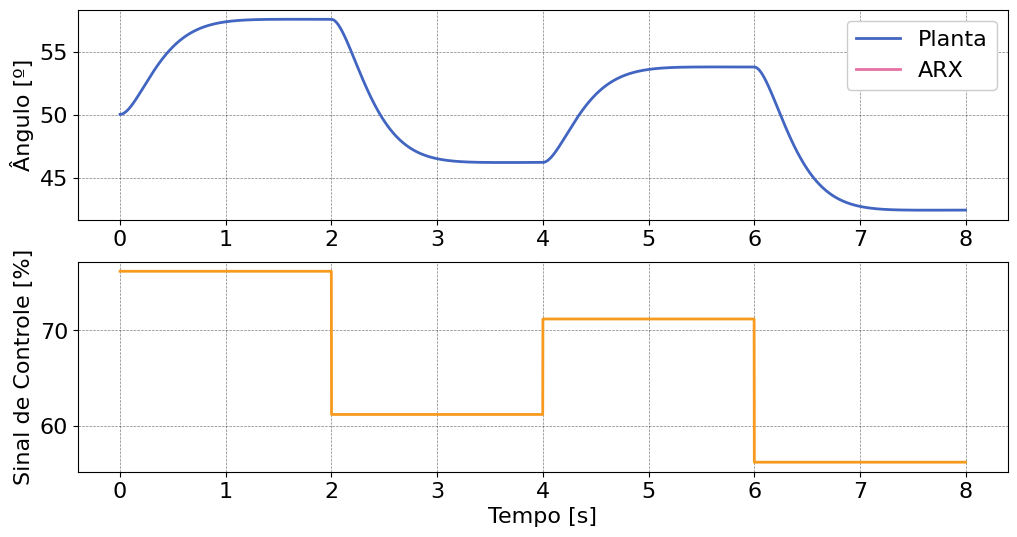

In [10]:
#Criação de degraus para validação do modelo:
uvalid = np.hstack((np.ones(int(tdeg/ts))*ueq, np.ones(int(tdeg/ts))*(ueq+10), np.ones(int(tdeg/ts))*(ueq-5), np.ones(int(tdeg/ts))*(ueq+5), np.ones(int(tdeg/ts))*(ueq-10)))
tvalid = np.arange(0, int(5*tdeg*1e-3), ts*1e-3)

#Simulação do modelo ARX:
yarx = np.ones(n)*pop
for k in range(n, len(uvalid)):
    psi = np.hstack((np.flip(yarx[k-n:k-1]), np.flip(uvalid[k-n:k])))
    yk = psi@THETA
    yarx = np.hstack((yarx, yk))

#Simulação da planta:
tvalid, yplanta = ct.forced_response(G, tvalid, uvalid)

#Decupagem dos dados:
tvalid = tvalid[int(tdeg/ts):]-int((int(tdeg/ts))*1e-3)
uvalid = uvalid[int(tdeg/ts):]
yplanta = yplanta[int(tdeg/ts):]
yarx = yarx[int(tdeg/ts):]

#Plot da resposta:
plt.subplots(sharex=True)
plt.subplot(2, 1, 1)
plt.plot(tvalid, yplanta, color='C0', label='Planta')
plt.plot(tvalid, yarx, color='C1', label='ARX')
plt.ylabel('Ângulo [º]')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(tvalid, uvalid, color='C4')
plt.ylabel('Sinal de Controle [%]')
plt.xlabel('Tempo [s]')
plt.show()